<a href="https://colab.research.google.com/github/seoirsem/Colab_Notebooks/blob/main/Modular_Addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00


In [ ]:
pip install transformer_lens

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import time
import random
import math
import einops
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

from typing import List, Union, Optional


In [4]:
def timer(fn):
  def wrapper(*args, **kwargs):
    t_start = time.time()
    out = fn(*args, **kwargs)
    t_elapsed = time.time() - t_start
    print('The function "{}" took {}s to run'.format(fn.__name__,str(round(t_elapsed,3))))
    return out
  return(wrapper)

In [5]:
####### constants #########
frac_train = 0.7
p = 113
seed = 555
lr = 1e-3
wd = 1.
betas = (0.9,0.98)




In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
dataset = torch.stack([a_vector, b_vector], dim=1).to(device)
labels = (dataset[:, 0] + dataset[:, 1]) % p

#labels = torch.zeros([dataset.shape[0],113])
#for i in range(dataset.shape[0]):
  #print(dataset[i, 0].item(), dataset[i, 1].item(), (((dataset[i, 0] + dataset[i, 1]) % p)).item())
 # labels[i,((dataset[i, 0] + dataset[i, 1]) % p).item()] = 1
#labels = (dataset[:, 0] + dataset[:, 1]) % p
labels = labels.to(device)
print(dataset[:5])
print(dataset.shape)
print(labels[:5])
print(labels.shape)

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4]], device='cuda:0')
torch.Size([12769, 2])
tensor([0, 1, 2, 3, 4], device='cuda:0')
torch.Size([12769])


In [8]:
@timer
def test_train_split(data, classes, random_seed : int, p_train : float):
  indices = list(range(len(data)))
  np.random.seed(random_seed)
  np.random.shuffle(indices)
  split_index = math.ceil(len(data) * (1-p_train))
  i_train = indices[:split_index]
  i_test = indices[split_index:]
  train_data = data[i_train]
  train_labels = classes[i_train]
  test_data = data[i_test]
  test_labels = classes[i_test]
  return train_data, train_labels, test_data, test_labels

In [9]:
def run_test_set(test_data, test_labels, model):
    model.eval()
    pred = model(test_data)
    n = pred.shape[0]
    count_correct = 0
    for i in range(n):
        top_values, top_indices = torch.topk(pred[i],2)
        label = torch.argmax(test_labels[i])
        count_correct += int(top_indices[0] == label)
    model.train()
    return count_correct/n

In [10]:

cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p,
    d_vocab_out=p,
    n_ctx=2,
    init_weights=True,
    device="cuda",
    seed = 999,
)


In [11]:
class Model(nn.Module):
    def __init__(self, l_in, l_mid, l_out):
        super(Model,self).__init__()


        self.network_seq = nn.Sequential(
        nn.Linear(l_in,l_mid),
        nn.ReLU(),
        nn.Linear(l_mid, l_mid),
        nn.ReLU(),
        nn.Linear(l_mid,l_out),
        nn.Softmax()
        )

    def forward(self, x):
      out = self.network_seq(x)
      return out

In [12]:
train_data, train_labels, test_data, test_labels = test_train_split(dataset, labels, seed, frac_train)
train_data = train_data
train_labels = train_labels
test_data = test_data
test_labels = test_labels
print(train_data[:5])
print(train_labels[:2])


The function "test_train_split" took 0.023s to run
tensor([[110,   3],
        [ 21, 107],
        [102,   8],
        [  7,  86],
        [ 45,  11]], device='cuda:0')
tensor([ 0, 15], device='cuda:0')


In [13]:
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()

def run_test(test_data, test_labels, model):
  model.eval()
  pred = model(test_data)
  if len(pred.shape)==3:
      pred = pred[:, -1]
  #print(pred.shape)#.log_softmax(dim=-1)
  n = pred.shape[0]
  count_correct = 0
  for i in range(n):
      top_index = torch.argmax(pred[i])
      #label = torch.argmax(test_labels[i])
      #print(test_labels[i])
      #print(top_index,label)
      #if i == 3:
       # break
      count_correct += int(top_index == test_labels[i])
  model.train()
  return count_correct/n

model = HookedTransformer(cfg)#Model(2,512,113).to(device)
loss_function = loss_fn#nn.BCELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False

run_test(test_data,test_labels,model)


0.009286193779368986

In [14]:
model(train_data)[0]
print(train_data.shape)
print(model(train_data).shape)
print(torch.squeeze(model(train_data)).shape)
print(torch.squeeze(model(train_data))[:, -1].shape)
#print(math.log(113))
loss_function(torch.squeeze(model(train_data)),train_labels)

torch.Size([3831, 2])
torch.Size([3831, 2, 113])
torch.Size([3831, 2, 113])
torch.Size([3831, 113])


tensor(4.7357, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)

In [15]:
losses = []
correct_in_test = []
correct_in_train = []
test_losses = []

In [16]:
epochs = 1000
n_show = 1000
n_train_loss = 50

In [17]:
start = time.time()
for i in range(epochs):
    optimiser.zero_grad()
    yPrediction = torch.squeeze(model(train_data))
    #print(yPrediction.shape, train_labels.shape)
    #print(yPrediction[0],data[1][0])
    loss = loss_function(yPrediction, train_labels)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())
   # print(yPrediction.shape)
   # print(train_labels.shape)
    if (i+1) % n_train_loss == 0:
      test_losses.append(loss_function(torch.squeeze(model(test_data)),test_labels).item())
    if (i+1) % n_show == 0:
        correct_in_test.append(run_test(test_data, test_labels,model))
        correct_in_train.append(run_test(train_data, train_labels,model))
        print('Epoch [{}/{}] in {:.2f}s, log loss of {:.3f}, train_set: {:.1f}%, test_set: {:.1f}%'.format(i+1,epochs,time.time()-start,math.log(losses[-1]),100*correct_in_train[-1],100*correct_in_test[-1]))
        start = time.time()


Epoch [1000/1000] in 14.57s, log loss of -11.928, train_set: 100.0%, test_set: 1.9%


# Plot outputs

In [18]:
print(train_data[:10])
print(train_labels[:10])
#print(model(train_data)[1])
print(torch.argmax(model(train_data)[1][0]))


tensor([[110,   3],
        [ 21, 107],
        [102,   8],
        [  7,  86],
        [ 45,  11],
        [ 40, 112],
        [ 79,  92],
        [ 55,  98],
        [ 24,  28],
        [ 96,  84]], device='cuda:0')
tensor([  0,  15, 110,  93,  56,  39,  58,  40,  52,  67], device='cuda:0')
tensor(45, device='cuda:0')


Text(0, 0.5, 'Loss')

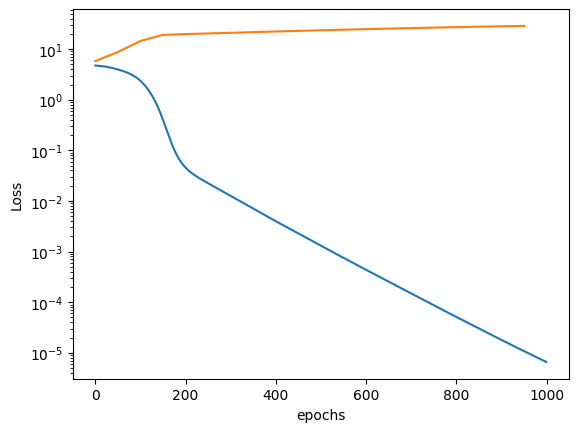

In [19]:
plt.plot(losses)
plt.plot([n_train_loss*i for i in range(len(test_losses))],test_losses)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Proportion Correct')

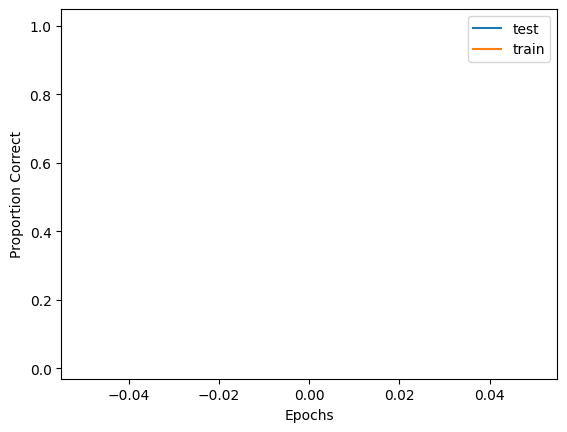

In [20]:
plt.figure()
plt.plot([i*n_show for i in range(len(correct_in_test))],correct_in_test, label = 'test')
plt.plot([i*n_show for i in range(len(correct_in_test))],correct_in_train, label = 'train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Proportion Correct')

# Looking at the model


In [21]:
original_logits, cache = model.run_with_cache(dataset)
#cache = cache.cpu()

In [22]:
W_E = model.embed.W_E[:-1]
print("W_E", W_E.shape)
W_neur = W_E @ model.blocks[0].attn.W_V @ model.blocks[0].attn.W_O @ model.blocks[0].mlp.W_in
print("W_neur", W_neur.shape)
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

W_E torch.Size([112, 128])
W_neur torch.Size([4, 112, 512])
W_logit torch.Size([512, 113])


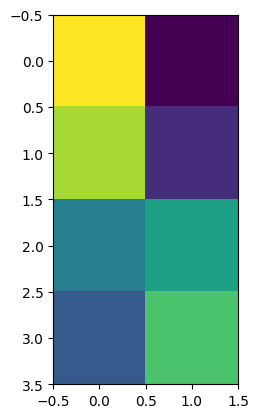

In [23]:
plt.imshow(cache["pattern", 0].mean(dim=0)[:, -1, :].cpu())

## SVD

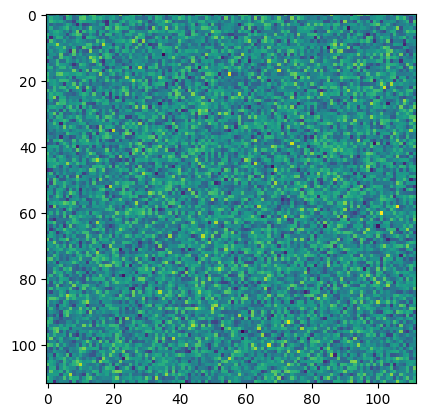

In [24]:
U, S, Vh = torch.svd(W_E)
#plt.line(S, title="Singular Values")
plt.imshow(U.detach().cpu())

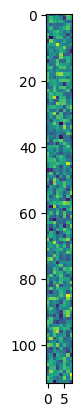

In [25]:
plt.imshow(U.detach().cpu()[:,:8])


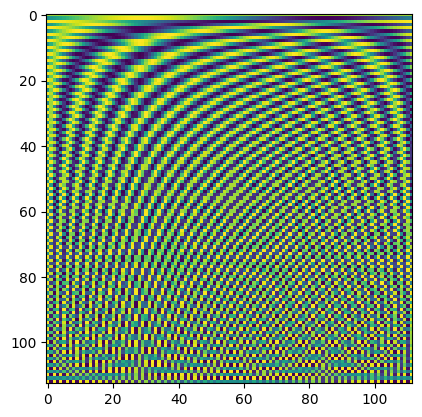

In [26]:
fourier_basis = []
fourier_basis_names = []
fourier_basis.append(torch.ones(p-1))
fourier_basis_names.append("Constant")
for freq in range(1, p//2+1):
    fourier_basis.append(torch.sin(torch.arange(p-1)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Sin {freq}")
    fourier_basis.append(torch.cos(torch.arange(p-1)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Cos {freq}")
#print(len(fourier_basis))
fourier_basis = torch.stack(fourier_basis, dim=0)
fourier_basis = fourier_basis/fourier_basis.norm(dim=-1, keepdim=True)
plt.imshow(fourier_basis)

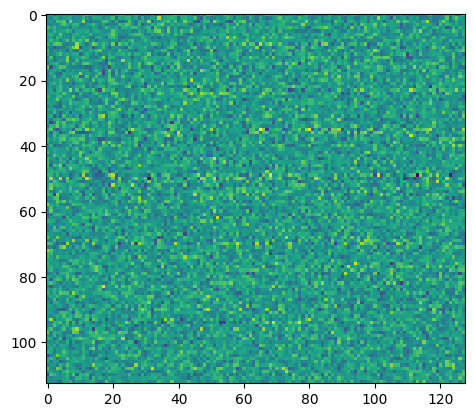

In [27]:
plt.imshow(fourier_basis @ W_E.detach().cpu())

Text(0.5, 0, 'Frequency')

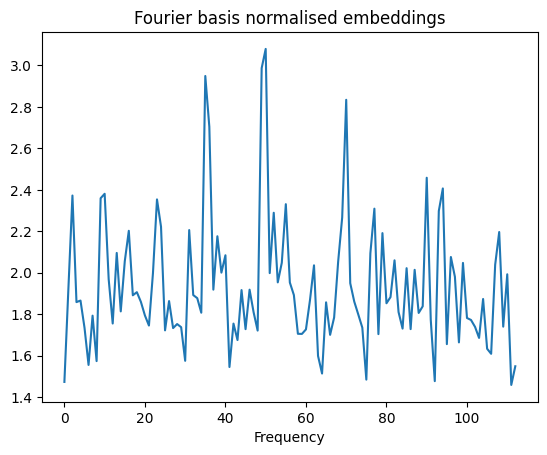

In [28]:
primary_values = fourier_basis @ W_E.detach().cpu()
normalised = primary_values.norm(dim = -1)
plt.plot(normalised)
plt.title("Fourier basis normalised embeddings")
plt.xlabel('Frequency')

In [29]:
torch.topk(normalised.flatten(), 10).indices

tensor([50, 49, 35, 70, 36, 90, 94, 10,  2,  9])

# Train and find frequencies across primes

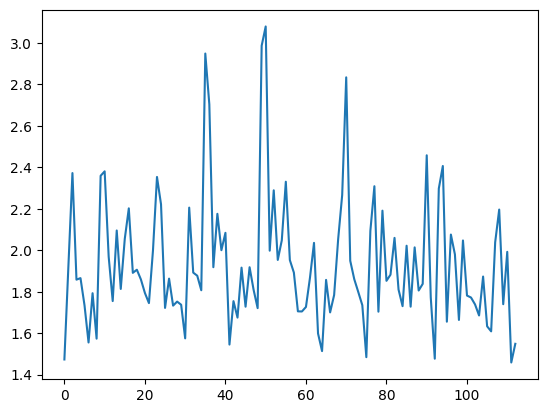

In [39]:
def find_key_frequencies(model,p):
  W_E = model.embed.W_E[:-1]
  fourier_basis = []
  fourier_basis_names = []
  fourier_basis.append(torch.ones(p-1))
  fourier_basis_names.append("Constant")
  for freq in range(1, p//2+1):
      fourier_basis.append(torch.sin(torch.arange(p-1)*2 * torch.pi * freq / p))
      fourier_basis_names.append(f"Sin {freq}")
      fourier_basis.append(torch.cos(torch.arange(p-1)*2 * torch.pi * freq / p))
      fourier_basis_names.append(f"Cos {freq}")
  #print(len(fourier_basis))
  fourier_basis = torch.stack(fourier_basis, dim=0)
  fourier_basis = fourier_basis/fourier_basis.norm(dim=-1, keepdim=True)
  primary_values = fourier_basis @ W_E.detach().cpu()
  normalised = primary_values.norm(dim = -1)
  return normalised


plt.plot(find_key_frequencies(model,113))

In [31]:
@timer
def train_model(p_in, seed, epochs):
  frac_train = 0.7
  p = p_in
  seed = seed
  lr = 1e-3
  wd = 1.
  betas = (0.9,0.98)

  a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
  b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
  dataset = torch.stack([a_vector, b_vector], dim=1).to(device)
  labels = (dataset[:, 0] + dataset[:, 1]) % p
  labels = labels.to(device)

  train_data, train_labels, test_data, test_labels = test_train_split(dataset, labels, seed, frac_train)
  train_data = train_data
  train_labels = train_labels
  test_data = test_data
  test_labels = test_labels

  model = HookedTransformer(cfg)
  loss_function = loss_fn
  optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

  for name, param in model.named_parameters():
      if "b_" in name:
          param.requires_grad = False

  run_test(test_data,test_labels,model)

  losses = []
  correct_in_test = []
  correct_in_train = []
  test_losses = []

  epochs = epochs
  n_show = 100
  n_train_loss = 50
  epochs_to_grok = 0
  start = time.time()
  for i in range(epochs):
      optimiser.zero_grad()
      yPrediction = torch.squeeze(model(train_data))
      #print(yPrediction.shape, train_labels.shape)
      #print(yPrediction[0],data[1][0])
      loss = loss_function(yPrediction, train_labels)
      loss.backward()
      optimiser.step()
      losses.append(loss.item())
    # print(yPrediction.shape)
    # print(train_labels.shape)
      if (i+1) % n_train_loss == 0:
        test_losses.append(loss_function(torch.squeeze(model(test_data)),test_labels).item())
      if (i+1) % n_show == 0:
          correct_in_test.append(run_test(test_data, test_labels,model))
          correct_in_train.append(run_test(train_data, train_labels,model))
          print('Epoch [{}/{}] of prime {} and seed {} in {:.2f}s, log loss of {:.3f}, train_set: {:.1f}%, test_set: {:.1f}%'.format(i+1,epochs,p,seed,time.time()-start,math.log(losses[-1]),100*correct_in_train[-1],100*correct_in_test[-1]))
          start = time.time()
          if (correct_in_test[-1] > 0.5) and epochs_to_grok == 0:
            epochs_to_grok = i

  return [model, losses, n_train_loss, test_losses, n_show, correct_in_test, correct_in_train, epochs_to_grok, seed, p]

In [32]:
p = 113
seed = 111
epochs = 20000

outputs = []
for seed in [101,103,105, 107]:
  print('~~~~~~~~~~~ Running {}, {}, for {} epochs ~~~~~~~~~~~'.format(p,seed,epochs))
  outputs.append(train_model(p,seed,epochs))


~~~~~~~~~~~ Running 113, 101, for 20000 epochs ~~~~~~~~~~~
The function "test_train_split" took 0.01s to run
Epoch [100/20000] of prime 113 and seed 101 in 1.83s, log loss of 0.948, train_set: 34.8%, test_set: 0.0%
Epoch [200/20000] of prime 113 and seed 101 in 1.84s, log loss of -2.815, train_set: 100.0%, test_set: 0.3%
Epoch [300/20000] of prime 113 and seed 101 in 1.88s, log loss of -4.237, train_set: 100.0%, test_set: 0.4%
Epoch [400/20000] of prime 113 and seed 101 in 1.54s, log loss of -5.387, train_set: 100.0%, test_set: 0.4%
Epoch [500/20000] of prime 113 and seed 101 in 1.49s, log loss of -6.502, train_set: 100.0%, test_set: 0.6%
Epoch [600/20000] of prime 113 and seed 101 in 1.52s, log loss of -7.599, train_set: 100.0%, test_set: 0.7%
Epoch [700/20000] of prime 113 and seed 101 in 1.48s, log loss of -8.680, train_set: 100.0%, test_set: 0.9%
Epoch [800/20000] of prime 113 and seed 101 in 1.48s, log loss of -9.745, train_set: 100.0%, test_set: 1.0%
Epoch [900/20000] of prime 11

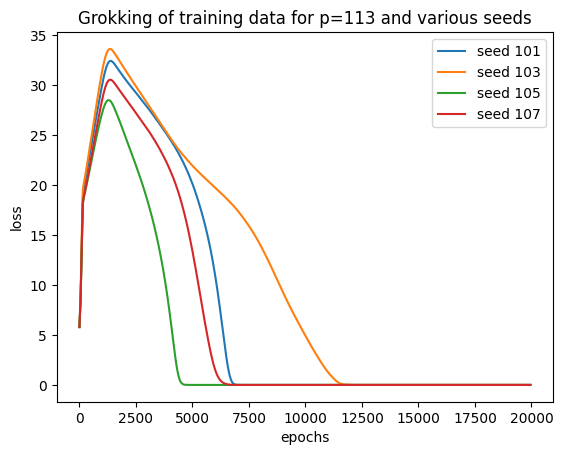

In [35]:

#[model, losses, n_train_loss, test_losses, n_show, correct_in_test, correct_in_train, epochs_to_grok, seed, p] = outputs[-1]
seeds = [101,103,105,107]
plt.figure()
for i in range(len(outputs)):
  m = outputs[i][0]
  losses = outputs[i][3]
#  plt.plot(find_key_frequencies(model,p))
  plt.plot([x*outputs[i][2] for x in range(len(losses))],(losses), label = 'seed {}'.format(seeds[i]))
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Grokking of training data for p=113 and various seeds')

#plt.title('Key Frequencies at {}, with seed {}'.format(p,seed))
############## remember log(113) is the random choice loss - these are much worse!

In [36]:
for i in range(len(outputs)):
  out = outputs[i]
  print('epochs to grok with seed {} was {}'.format(seeds[i],out[-3]+1))

epochs to grok with seed 101 was 6600
epochs to grok with seed 103 was 10300
epochs to grok with seed 105 was 4300
epochs to grok with seed 107 was 5900


Text(0.5, 1.0, 'Key frequencies for p=113 at various seeds')

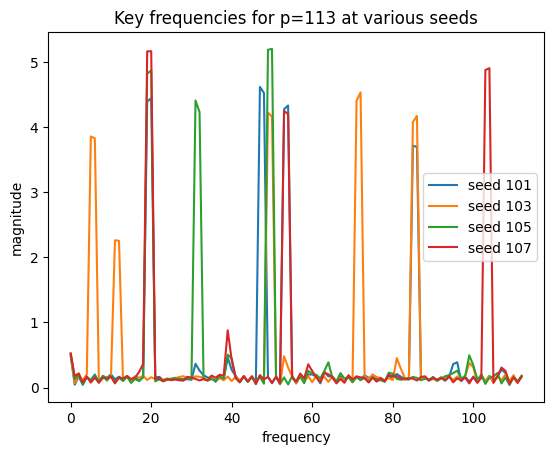

In [40]:
plt.figure()
keys = []
for i in range(len(outputs)):
  m = outputs[i][0]
  key = find_key_frequencies(m,113)
  keys.append(key)
  #losses = outputs[i][3]
#  plt.plot(find_key_frequencies(model,p))
  plt.plot(key, label = 'seed {}'.format(seeds[i]))
plt.legend()
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.title('Key frequencies for p={} at various seeds'.format(p))

In [46]:


for i in range(len(keys)):
  seed = seeds[i]
  key = keys[i]
  top_values, top_indices = torch.topk(key,12)
  print('p={}, seed={}'.format(p,seed))
  print('Top values',top_values)
  print('Top indices',top_indices)


p=113, seed=101
Top values tensor([4.6194, 4.5284, 4.4442, 4.3962, 4.3338, 4.2780, 3.7148, 3.6989, 0.4894,
        0.4604, 0.3877, 0.3640])
Top indices tensor([47, 48, 20, 19, 54, 53, 85, 86,  0, 39, 96, 31])
p=113, seed=103
Top values tensor([4.5355, 4.4058, 4.2235, 4.1737, 4.1635, 4.0810, 3.8584, 3.8298, 2.2631,
        2.2539, 0.4971, 0.4803])
Top indices tensor([72, 71, 49, 86, 50, 85,  5,  6, 11, 12,  0, 53])
p=113, seed=105
Top values tensor([5.2037, 5.1910, 4.8734, 4.8246, 4.4114, 4.2331, 0.5204, 0.5048, 0.4948,
        0.4474, 0.3873, 0.3429])
Top indices tensor([ 50,  49,  20,  19,  31,  32,   0,  39,  99,  40,  64, 100])
p=113, seed=107
Top values tensor([5.1678, 5.1660, 4.9080, 4.8795, 4.2490, 4.2027, 0.8791, 0.5230, 0.4166,
        0.3641, 0.3567, 0.3071])
Top indices tensor([ 20,  19, 104, 103,  53,  54,  39,   0,  40,  18,  59, 107])


# Across Primes

In [ ]:
p = 113
seed = 111
epochs = 20000

primes = [101,103]
outputs = []
for p in primes:
  print('~~~~~~~~~~~ Running {}, {}, for {} epochs ~~~~~~~~~~~'.format(p,seed,epochs))
  outputs.append(train_model(p,seed,epochs))

In [ ]:

#[model, losses, n_train_loss, test_losses, n_show, correct_in_test, correct_in_train, epochs_to_grok, seed, p] = outputs[-1]
p =
plt.figure()
for i in range(len(outputs)):
  m = outputs[i][0]
  losses = outputs[i][3]
#  plt.plot(find_key_frequencies(model,p))
  plt.plot([x*outputs[i][2] for x in range(len(losses))],(losses), label = 'seed {}'.format(seeds[i]))
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Grokking of training data for p=113 and various seeds')